## Introduction

The goal of this script is to build a macroeconomic model that predicts changes in monthly median price. On the basis of this model, I select features to be added to the final model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from datetime import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
datadir = '~/Desktop/sberbank_samen/data/'

In [3]:
df_macro = pd.read_csv(datadir + 'macro.csv')
df_train = pd.read_csv(datadir +'train.csv')
df_test = pd.read_csv(datadir + 'test.csv')

In [4]:
def extract_date_variables(input_data, date_in_index=False):
    
    '''This function extracts data variables from a series or index of a series. Returns
        a DataFrame with extracted variables'''

    if date_in_index:
        
        #input_data['weeknr'] = map(lambda x: str(x), input_data.index.week)
        input_data['year'] = map(lambda x: str(x), input_data.index.year)
        input_data['month'] = map(lambda x: str(x), input_data.index.month)

        #input_data['week_year'] = input_data['weeknr'] + '_' + input_data['year']
        input_data['month_year'] = input_data['month'] + '_' + input_data['year']

        return input_data
    
    else:
        output_data = input_data.to_frame(name='timestamp')
        
        #output_data['weeknr'] = map(lambda x: str(x.week), output_data['timestamp'])
        output_data['year'] = map(lambda x: str(x.year), output_data['timestamp'])
        output_data['month'] = map(lambda x: str(x.month), output_data['timestamp'])

        #output_data['week_year']  = output_data['weeknr'] + '_' + output_data['year']
        output_data['month_year'] = output_data['month'] + '_' + output_data['year']

        return output_data

## Macro target: monthly median prices (log)

In [5]:
price_data = df_train[['timestamp','price_doc']].copy()
price_data['timestamp'] = pd.to_datetime(price_data['timestamp'] )
price_data = df_train[['timestamp', 'price_doc']].copy()
prices = price_data.groupby(price_data['timestamp']).median()

prices.index = map(lambda x: pd.to_datetime(x), prices.index)
prices_timevar = extract_date_variables(prices, True)

med_price_monthly = prices_timevar.groupby('month_year', as_index=False, sort = False).median()

y_train = pd.Series(np.log(med_price_monthly.price_doc.values), index=med_price_monthly.month_year.values).to_frame(name='price_doc')

## Macro data preprocessing

Add date variables:

In [6]:
df_macro['timestamp'] = pd.to_datetime(df_macro['timestamp'])

df_macro = pd.concat([df_macro, extract_date_variables(df_macro['timestamp']).iloc[:,2:] ], axis=1)


In [7]:
# fill NA
df_macro.fillna(method='ffill', inplace=True)
df_macro.fillna(method='bfill', inplace=True)


# aggregate
df_macro_monthly = df_macro.groupby('month_year', sort=False).median()

Merge with target variable and take first differences:

In [8]:
df_macro_monthly = df_macro_monthly.merge(y_train, left_index=True, right_index=True)

In [9]:
df_macro_monthly_diff = df_macro_monthly.diff().iloc[1:,:]

In [10]:
X = df_macro_monthly_diff.drop('price_doc', axis=1)
y = df_macro_monthly_diff['price_doc']

## Random forest macro model

In [11]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [12]:
rf = RandomForestRegressor(n_jobs=-1)
pca = decomposition.PCA(whiten=True)
scl = StandardScaler()

In [13]:
pipe = Pipeline([('scaler', scl), ('pca', pca), ('rf', rf)])

In [14]:
n_comp = [5, 10, 15, 20, None]

In [15]:
estimator = GridSearchCV(pipe, dict(pca__n_components = n_comp), n_jobs=-1)

In [16]:
result = estimator.fit(X,y)

In [17]:
result.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_fea...imators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [18]:
result.best_score_

-0.35886390948091873

Fit and visualise 'best' model

In [19]:
rf1 = RandomForestRegressor(n_jobs=-1)
rf2 = RandomForestRegressor(n_jobs=-1)

pca = decomposition.PCA(whiten=True, n_components=15)

scl1 = StandardScaler()
scl2 = StandardScaler()


pipe1 = Pipeline([('scaler', scl1), ('pca', pca), ('rf', rf1)])
pipe2 = Pipeline([('scaler', scl2), ('rf', rf2)])

In [20]:
est_model = pipe1.fit(X,y)

In [21]:
predictions = pipe1.predict(X)

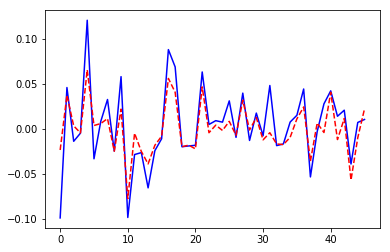

In [22]:
plt.plot(y.values, 'b-', predictions, 'r--')

Plot prediction error outside training set:

In [23]:
X_train = X.iloc[:30,:]
y_train = y.iloc[:30]

X_test = X.iloc[30:,:]
y_test = y.iloc[30:]

In [24]:
#est_model1 = pipe1.fit(X_train, y_train)
est_model2 = pipe2.fit(X_train, y_train)

In [25]:
#predictions1 = est_model1.predict(X_test)
predictions2 = est_model2.predict(X_test)

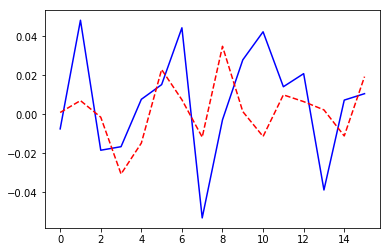

In [26]:
plt.plot(y_test.values, 'b-', predictions2, 'r--')

Select most important features:

In [27]:
FI = pd.DataFrame(dict(cols=X.columns, importance=est_model2.named_steps['rf'].feature_importances_))

In [28]:
FI.sort_values('importance', ascending=False)

,cols,importance
6,balance_trade,0.226182
18,micex_rgbi_tr,0.144730
42,unprofitable_enterpr_share,0.061531
4,ppi,0.057664
75,rent_price_1room_eco,0.056211
48,construction_value,0.053917
24,mortgage_growth,0.051132
70,rent_price_3room_bus,0.049746
61,hot_water_share,0.044073
72,rent_price_1room_bus,0.042834


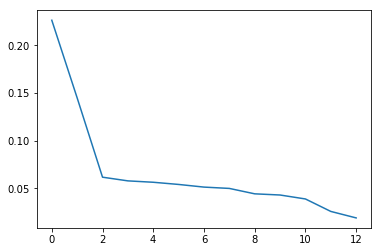

In [29]:
plt.plot(FI.sort_values('importance', ascending=False).importance.iloc[:13].values )

In [30]:
macro_features = FI.sort_values('importance', ascending=False).cols.iloc[:12].values

In [31]:
macro_features

array(['balance_trade', 'micex_rgbi_tr', 'unprofitable_enterpr_share',
       'ppi', 'rent_price_1room_eco', 'construction_value',
       'mortgage_growth', 'rent_price_3room_bus', 'hot_water_share',
       'rent_price_1room_bus', 'rent_price_2room_eco', 'deposits_growth'], dtype=object)

In [32]:
pd.Series(macro_features).to_csv(datadir + 'macro_features_rf.csv')